# pip et imports

In [ ]:
!pip install umap-learn[plot]
!pip install holoviews #pyplot
!pip install -U ipykernel
!pip install keras
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.1 MB/s eta 0:00:00
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 6.17.1
    Uninstalling ipykernel-6.17.1:
      Successfully uninstalled ipykernel-6.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==6.17.1, but you have ipykernel 6.29.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.7 MB/s eta 0:00:00


In [ ]:

#Sickit learn met régulièrement à jour des versions et
#indique des futurs warnings.
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle
import pandas as pd
from scipy.stats import randint
import numpy as np
import string
import time
import base64
import re
import sys
import copy

import os
from os import listdir
from os.path import isfile, join


# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import plotly.graph_objs as go
import plotly.offline as py

from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


# TensorFlow et keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
#from keras.preprocessing.image import ImageDataGenerator #J'ai (amine) enlever cette ligne, si qlq chose marche pas c de ma faute hhhh
#from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.preprocessing import image
from tqdm import tqdm
from keras.models import load_model

import librosa
from IPython.display import Audio
from scipy.io import wavfile


# Umap
import umap.plot
from bokeh.plotting import output_notebook
from bokeh.plotting import *
from bokeh.plotting import figure, show, output_notebook

import optuna

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning:

Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba

/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning:

Failed to dlopen libcuda.so.1

/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning:

Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in

# fonctions utiles

In [ ]:
import random as rd
# represente la classe si elle est exacte (1 ou 0)
def reprClasse(x):
  return "chien" if x == 1 else "chat"

# même chose mais si la classe est une proba (ex : 0.98 -> 1 -> chien)
def reprClasseArondi(x):
  return "chat" if x < 0.5 else "chien"


# permet de visualiser n sons pour voir ce que le model a prédit
def testerAuHasardModel(model, X_test, Y_test, n):
  y_pred = model.predict(X_test, verbose=0)
  nb_tested = 0
  tested = []
  if n > len(Y_test):
    n = len(Y_test)
  while nb_tested < n:
    i = rd.randint(0,len(Y_test)-1)
    if i in tested:
      continue
    print(f"prédit : {reprClasse(y_pred[i])}, réalité : {reprClasse(Y_test[i][0])}")
    display(Y_test[i][1])
    nb_tested +=1


In [ ]:
# plot les courbes de plusieurs histories
def plot_curves(histories):
    plt.figure(1,figsize=(16,6))
    plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1,
                          top = 0.9, wspace = 0.25, hspace = 0)
    for i in range(len(histories)):
    	# plot loss
    	plt.subplot(121)
    	plt.title('Cross Entropy Loss')
    	plt.plot(histories[i].history['loss'], color='blue', label='train')
    	plt.plot(histories[i].history['val_loss'], color='red', label='test')
    	plt.ylabel('loss')
    	plt.xlabel('epoch')
    	plt.legend(['Training loss', 'Validation loss'], loc='upper left')
    	# plot accuracy
    	plt.subplot(122)
    	plt.title('Classification Accuracy')
    	plt.ylabel('accuracy')
    	plt.xlabel('epoch')
    	plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    	plt.plot(histories[i].history['val_accuracy'], color='red',
                 label='test')
    	plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
    plt.show()

# plot la courbe d'une seule history
def plot_curves_unique(history):
	plot_curves([history])

In [ ]:
def plot_curves_confusion (history,confusion_matrix):
  plt.figure(1,figsize=(16,6))
  plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1,
                          top = 0.9, wspace = 0.25, hspace = 0)

  # division de la fenêtre graphique en 1 ligne, 3 colonnes,
  # graphique en position 1 - loss fonction

  plt.subplot(1,3,1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Training loss', 'Validation loss'], loc='upper left')
  # graphique en position 2 - accuracy
  plt.subplot(1,3,2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')

  class_names = ["chat", "chien"]

  # matrice de correlation
  plt.subplot(1,3,3)
  sns.heatmap(conf,annot=True,fmt="d",cmap='Blues',xticklabels=class_names, yticklabels=class_names)# label=class_names)
  # labels, title and ticks
  plt.xlabel('Predicted', fontsize=12)
  #plt.set_label_position('top')
  #plt.set_ticklabels(class_names, fontsize = 8)
  #plt.tick_top()
  plt.title("Correlation matrix")
  plt.ylabel('True', fontsize=12)
  #plt.set_ticklabels(class_names, fontsize = 8)
  plt.show()

In [ ]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform



# reglages du notebook

La cellule suivante permet de regler quel dataset on utilise: vgg_dataset ou cats_dogs.

Ils sont tous les deux au même format (2 dossiers cat et dog avec des .wav à l'interieur), on peut donc lancer le notebook sur l'un ou l'autre sans problème

In [ ]:
data_set_path = "vgg_dataset"

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
my_local_drive='/content/gdrive/MyDrive/projet S6/notebook intermediaires/chien-chat'
%cd $my_local_drive

Mounted at /content/gdrive
/content/gdrive/MyDrive/projet S6/notebook intermediaires/chien-chat


# Importation des données

## Chats

In [ ]:
from IPython.display import Audio

mypath=f'{data_set_path}/cat'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]

# liste utiliser pour l'affichage
sons_chat_display = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  sons_chat_display[n] = Audio(join(mypath,onlyfiles[n]), autoplay=False)


sons_chat = np.empty(len(onlyfiles), dtype=object)
for n in range(len(onlyfiles)):
  signal, sr = librosa.load(join(mypath,onlyfiles[n]), sr=None)  # sr=None pour conserver la fréquence d'échantillonnage originale
  sons_chat[n] = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)


# affichage
COLUMNS = 5 # Nombre de sons à afficher

for i in range(COLUMNS):
    display(sons_chat_display[i])


## Chiens

In [ ]:
from IPython.display import Audio

mypath=f'{data_set_path}/dog'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]

# liste utiliser pour l'affichage
sons_chien_display = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  sons_chien_display[n] = Audio(join(mypath,onlyfiles[n]), autoplay=False)
  #sons_chat[n] = cv2.imread( join(mypath,onlyfiles[n]) )


sons_chien = np.empty(len(onlyfiles), dtype=object)
for n in range(len(onlyfiles)):
  signal, sr = librosa.load(join(mypath,onlyfiles[n]), sr=None)  # sr=None pour conserver la fréquence d'échantillonnage originale
  sons_chien[n] = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)


# affichage
COLUMNS = 5 # Nombre d'images à afficher

plt.figure(figsize=(15,15))
for i in range(COLUMNS):
    # cv2 lit met les images en BGR et matplotlib lit du RGB
    # il faut donc convertir pour afficher les bonnes couleurs
    display(sons_chien_display[i])


# liste utilisé pour charger les sons dans pythons (utilisables)

<Figure size 1500x1500 with 0 Axes>

## padding des données et création de X et Y

In [ ]:
desired_length = max (max([len(k[0]) for k in sons_chat]), max([len(k[0]) for k in sons_chien]) )
LENGTH_SOUND = desired_length
sons_chat_padded = np.empty(len(sons_chat), dtype=object)
for i in range(len(sons_chat)):
  padded = np.pad(sons_chat[i], ((0, 0), (0, max(0, desired_length - sons_chat[i].shape[1]))), mode='constant')
  sons_chat_padded[i] = padded

sons_chien_padded = np.empty(len(sons_chien), dtype=object)
for i in range(len(sons_chien)):
  padded = np.pad(sons_chien[i], ((0, 0), (0, max(0, desired_length - sons_chien[i].shape[1]))), mode='constant')
  sons_chien_padded[i] = padded



In [ ]:
X = np.concatenate((sons_chat_padded, sons_chien_padded))
# Y contient l'animal et le son associé
Y = np.array([[0, sons_chat_display[i]] for i in range(len(sons_chat))] + [[1, sons_chien_display[i]] for i in range(len(sons_chien))])
y = np.array([k[0] for k in Y])
labels = {
    0 : "chat",
    1 : "chien"
}


# visualisation des données

In [ ]:
nb_sons = len(X)
sons_reshaped = np.empty((nb_sons, LENGTH_SOUND * 13))
for i in range(nb_sons):
  sons_reshaped[i] = X[i].reshape((  LENGTH_SOUND * 13))

In [ ]:

Target_names = np.array(["chat" if k == 0 else "chien" for k in y])

# Utilisation de PCA
pca = PCA(n_components=2)
pca.fit(sons_reshaped)
X_pca = pca.transform(sons_reshaped)

trace0 = go.Scatter(
    x = X_pca[:,0],
    y = X_pca[:,1],
    mode = 'markers',
    text = Target_names,
    showlegend = True,
    marker = dict(
        size = 8,
        color = y,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [trace0]

layout = go.Layout(
    title= 'Principal Component Analysis (PCA)',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)


fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(sons_reshaped)

traceTSNE = go.Scatter(
    x = tsne_results[:,0],
    y = tsne_results[:,1],
    text = Target_names,
    mode = 'markers',
    showlegend = True,
    marker = dict(
        size = 8,
        color = y,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [traceTSNE]

layout = dict(title = 'TSNE (T-Distributed Stochastic Neighbour Embedding)',
              hovermode= 'closest',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              showlegend= False,

             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

In [ ]:
import umap.plot
mapper = umap.UMAP().fit(sons_reshaped)

# utilisation d'un dataframe pour afficher les moints
hover_data = pd.DataFrame({'index':np.arange(nb_sons),
                           'label':y})
hover_data['item'] = hover_data.label.map(labels)

# affichage de la visualisation dans le notebook
umap.plot.output_notebook()

# Utilisation de umap en interactif
#p = umap.plot.interactive(mapper, labels=y_plot,
#                          hover_data=hover_data, point_size=6)
#umap.plot.show(p)
umap.plot.points(mapper, labels=y, theme='fire')

# model de test




In [ ]:
from sklearn.model_selection import train_test_split
trainsize = 0.8
testsize = 0.2

X_train,X_test,Y_train,Y_test=train_test_split(X,
                                               Y,
                                               train_size=trainsize,
                                               test_size=testsize)
y_train = np.array([np.array(k[0]) for k in Y_train])
y_test = np.array([np.array(k[0]) for k in Y_test])
X_train = np.stack(X_train, axis=0)
X_test = np.stack(X_test, axis=0)

# cellule de la section précédente

In [ ]:
modelTest = Sequential()
modelTest.add(layers.Conv2D(filters = 10, input_shape = (13,LENGTH_SOUND, 1), kernel_size = (13,10),  activation = "relu"))
modelTest.add(MaxPooling2D(pool_size=(1, 20)))
modelTest.add(layers.Flatten())
modelTest.add(Dense(60, activation='relu'))
modelTest.add(layers.Dense(1, activation='sigmoid'))
modelTest.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
modelTest.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1, 306, 10)     │         1,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 15, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60)             │         9,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,431 (40.75 KB)

 Trainable params: 10,431 (40.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = modelTest.fit(X_train, y_train,
              epochs=10,
              batch_size=64,
              validation_split=0.2,
              verbose=1)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6216 - loss: 5.5879 - val_accuracy: 0.7167 - val_loss: 0.9813
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7215 - loss: 0.8543 - val_accuracy: 0.7805 - val_loss: 0.5821
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7731 - loss: 0.5457 - val_accuracy: 0.8007 - val_loss: 0.5116
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7948 - loss: 0.4724 - val_accuracy: 0.7828 - val_loss: 0.5175
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7967 - loss: 0.4556 - val_accuracy: 0.7973 - val_loss: 0.4693
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8270 - loss: 0.3965 - val_accuracy: 0.8197 - val_loss: 0.4431
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8417 - loss: 0.3794 - val_accuracy: 0.8108 - val_loss: 0.4399
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8459 - loss: 0.3540 - val_accuracy: 0.8130 - val_loss

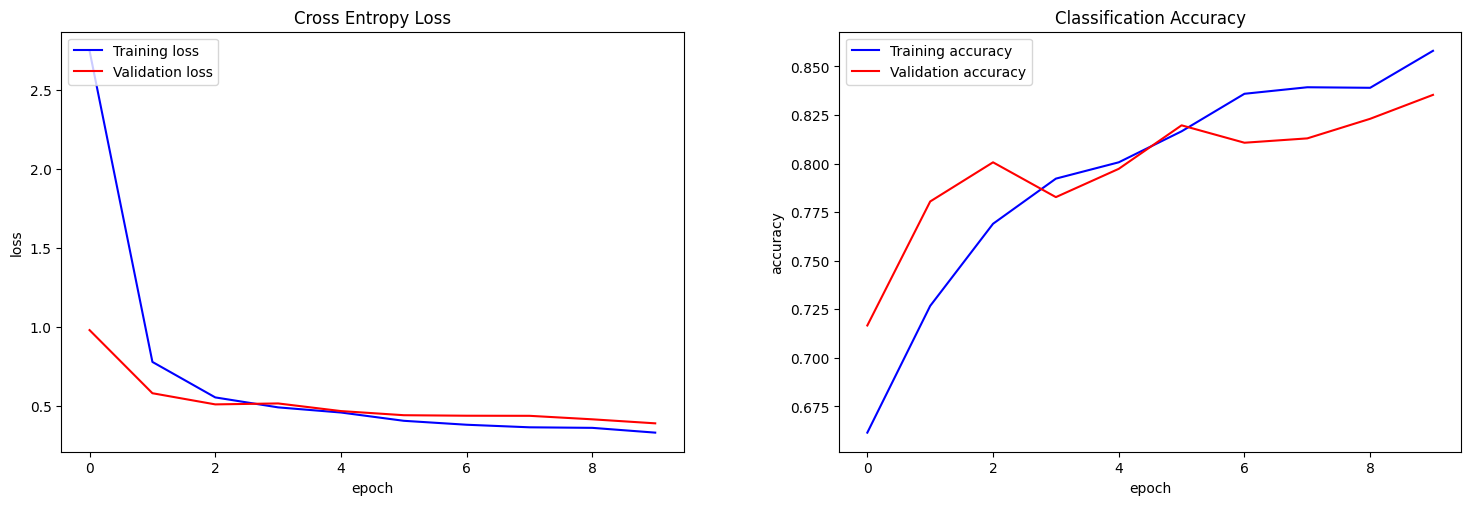

In [ ]:
plot_curves_unique(history)

# recherche des hyperparamètres avec optuna

In [ ]:
from sklearn.model_selection import train_test_split
trainsize = 0.8
testsize = 0.2

X_train,X_test,Y_train,Y_test=train_test_split(X,
                                               Y,
                                               train_size=trainsize,
                                               test_size=testsize)
y_train = np.array([np.array(k[0]) for k in Y_train])
y_test = np.array([np.array(k[0]) for k in Y_test])
X_train = np.stack(X_train, axis=0)
X_test = np.stack(X_test, axis=0)

# cellule de la section précédente

In [ ]:
def create_model(trial):
    # Some hyperparameters we want to optimize
    n_hidden = trial.suggest_int('n_hidden', 1, 3)
    n_filters = trial.suggest_int('n_filters', 5, 50)
    n_units = trial.suggest_int('n_units', 32, 128)
    n_convolution_size = trial.suggest_int('n_convolution_size', 10, 150)
    n_pooling_size = trial.suggest_int('n_pooling_size', 10, 150)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1) # ne sert à rien ???


    model = Sequential()
    model.add(layers.Conv2D(filters = n_filters, input_shape = (13,LENGTH_SOUND, 1), kernel_size = (13,n_convolution_size),  activation = "relu"))
    model.add(MaxPooling2D(pool_size=(1, n_pooling_size)))
    model.add(layers.Flatten())
    for i in range(n_hidden):
        model.add(Dense(n_units, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def objective(trial):
    model = create_model(trial)
    n_batch_size = trial.suggest_int('n_batch_size', 3, 7)
    model.fit(X_train, y_train,
              epochs=10,
              batch_size=2**n_batch_size,
              validation_split=0.2,
              verbose=0)
    score = model.evaluate(X_test, y_test, verbose=0)[1]
    return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2025-05-09 00:48:38,877] A new study created in memory with name: no-name-9951b7ec-ab4c-42fa-a6b2-fc5f9243d8df
[I 2025-05-09 00:48:54,560] Trial 0 finished with value: 0.8397493362426758 and parameters: {'n_hidden': 2, 'n_filters': 36, 'n_units': 104, 'n_convolution_size': 67, 'n_pooling_size': 134, 'learning_rate': 1.8813839245311427e-05, 'n_batch_size': 6}. Best is trial 0 with value: 0.8397493362426758.
[I 2025-05-09 00:48:59,880] Trial 0 finished with value: 0.8012533783912659 and parameters: {'n_hidden': 1, 'n_filters': 5, 'n_units': 128, 'n_convolution_size': 114, 'n_pooling_size': 137, 'learning_rate': 0.00030201443970497287, 'n_batch_size': 7}. Best is trial 0 with value: 0.8012533783912659.
[I 2025-05-09 00:49:02,163] Trial 1 finished with value: 0.8343778252601624 and parameters: {'n_hidden': 3, 'n_filters': 20, 'n_units': 111, 'n_convolution_size': 83, 'n_pooling_size': 41, 'learning_rate': 0.05741813123965258, 'n_batch_size': 7}. Best is trial 1 with value: 0.83437782526

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
study.best_params

{'n_hidden': 2,
 'n_filters': 27,
 'n_units': 82,
 'n_convolution_size': 18,
 'n_pooling_size': 144,
 'learning_rate': 2.3396580017108965e-05,
 'n_batch_size': 7}

In [ ]:
best_model = create_model(study.best_trial)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
best_model = Sequential()
best_model.add(layers.Conv2D(filters = 27, input_shape = (13,LENGTH_SOUND, 1), kernel_size = (13,18),  activation = "relu"))
best_model.add(MaxPooling2D(pool_size=(1, 144)))
best_model.add(layers.Flatten())
for i in range(2):
    best_model.add(Dense(82, activation='relu'))
best_model.add(layers.Dense(1, activation='sigmoid'))
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
history_best = best_model.fit(X_train, y_train,
              epochs=10,
              batch_size=2**3,
              validation_data=(X_test, y_test),
              verbose=1)

Epoch 1/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7747 - loss: 0.7764 - val_accuracy: 0.8299 - val_loss: 0.4062
Epoch 2/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8212 - loss: 0.4281 - val_accuracy: 0.7986 - val_loss: 0.4427
Epoch 3/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8370 - loss: 0.3845 - val_accuracy: 0.8299 - val_loss: 0.3961
Epoch 4/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8490 - loss: 0.3426 - val_accuracy: 0.8281 - val_loss: 0.4037
Epoch 5/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8467 - loss: 0.3617 - val_accuracy: 0.8550 - val_loss: 0.3799
Epoch 6/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8661 - loss: 0.3245 - val_accuracy: 0.8120 - val_loss: 0.4043
Epoch 7/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8708 - loss: 0.2965 - val_accuracy: 0.8577 - val_loss: 0.3518
Epoch 8/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8740 - loss: 0.2863 - val_ac

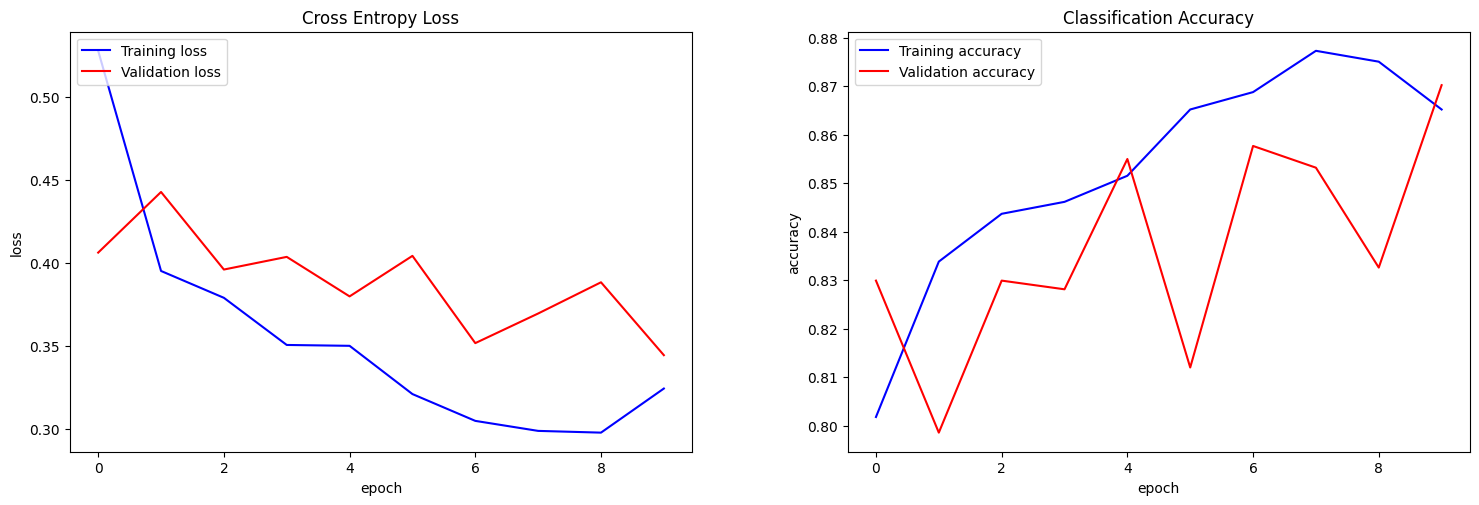

In [ ]:
plot_curves_unique(history_best)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


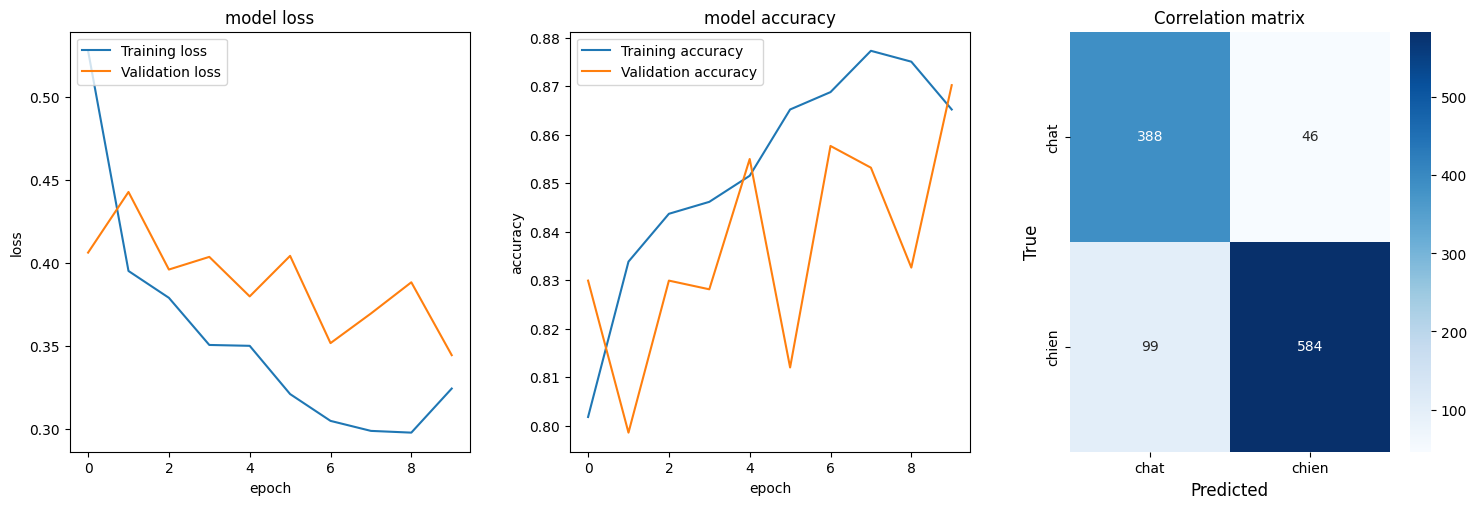

In [ ]:

y_pred = best_model.predict(X_test)
y_pred_rounded = [0 if k[0] <0.5 else 1 for k in y_pred]
conf=confusion_matrix(y_test,y_pred_rounded)
plot_curves_confusion(history_best, conf)

In [ ]:
best_model.save('model_rework_optuna.keras')

# Transfert learning avec Yamnet

## importation des données format pour yamnet et prétraitement



In [ ]:
"""from scipy.io import wavfile
from IPython.display import Audio


# wav_file_name = 'speech_whistling2.wav'
wav_file_name = 'vgg_dataset/cat/4.wav'
sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

# Show some basic information about the audio.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

# Listening to the wav file.
#display(Audio(wav_data, rate=sample_rate))


waveform = wav_data / tf.int16.max
scores, embeddings, spectrogram = yamnet_model(waveform)
"""



"from scipy.io import wavfile\nfrom IPython.display import Audio\n\n\n# wav_file_name = 'speech_whistling2.wav'\nwav_file_name = 'vgg_dataset/cat/4.wav'\nsample_rate, wav_data = wavfile.read(wav_file_name, 'rb')\nsample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)\n\n# Show some basic information about the audio.\nduration = len(wav_data)/sample_rate\nprint(f'Sample rate: {sample_rate} Hz')\nprint(f'Total duration: {duration:.2f}s')\nprint(f'Size of the input: {len(wav_data)}')\n\n# Listening to the wav file.\n#display(Audio(wav_data, rate=sample_rate))\n\n\nwaveform = wav_data / tf.int16.max\nscores, embeddings, spectrogram = yamnet_model(waveform)\n"

In [ ]:
from IPython.display import Audio

SAMPLE_RATE_CIBLE = 16000

mypath=f'{data_set_path}/cat'
onlyfiles = [ f"{mypath}/{f}" for f in listdir(mypath) if isfile(join(mypath,f)) ][:600]

cat_wave_datas = []
for filePath in onlyfiles:
  sample_rate, wav_data = wavfile.read(filePath, 'rb')
  sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data, desired_sample_rate=SAMPLE_RATE_CIBLE)
  cat_wave_datas.append(wav_data/tf.int16.max)


mypath=f'{data_set_path}/dog'
onlyfiles = [ f"{mypath}/{f}" for f in listdir(mypath) if isfile(join(mypath,f)) ][:600]

dog_wave_datas = []
for filePath in onlyfiles:
  sample_rate, wav_data = wavfile.read(filePath, 'rb')
  sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data, desired_sample_rate=SAMPLE_RATE_CIBLE)
  dog_wave_datas.append(wav_data/tf.int16.max)




In [ ]:
import tensorflow_hub as hub

yamnet_model = hub.load('https://www.kaggle.com/models/google/yamnet/TensorFlow2/yamnet/1')
yamnet_embedding_model = hub.KerasLayer(yamnet_model, trainable=False) # sans la classification finale



In [ ]:
cats = []
for son in cat_wave_datas:
  cats.append(yamnet_embedding_model(son)[1])

cats[0].shape

TensorShape([20, 1024])

In [ ]:
dogs = []
for son in dog_wave_datas:
  dogs.append(yamnet_embedding_model(son)[1])

In [ ]:
X = cats + dogs
y = [0 for _ in cats] + [1 for _ in dogs]

In [ ]:
"""#scores.mean(axis=0).argmax()
f = lambda x : x[1]
scores_mean = np.mean(scores, axis=0)
tab = []
for i in range(len(scores_mean)):
  tab.append((i, scores_mean[i]))
tab.sort(key= f)
tab = tab[::-1]
print(tab[:10])"""


[(67, 0.26203787), (68, 0.25115532), (76, 0.188946), (500, 0.14806524), (78, 0.08717125), (69, 0.046677496), (21, 0.044683255), (19, 0.04310833), (494, 0.04210492), (382, 0.034752592)]


## création du modèle

In [ ]:
# créations du split

In [ ]:
from sklearn.model_selection import train_test_split
trainsize = 0.8
testsize = 0.2

X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               train_size=trainsize,
                                               test_size=testsize)

# Convertir en numpy array avec float32
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Vérifier la forme
print("y_train.shape:", y_train.shape)  # Doit être (960,)
print("y_test.shape:", y_test.shape)  # Doit être (batch_size_test,)

y_train.shape: (960,)
y_test.shape: (240,)


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_time_steps = max([x.shape[0] for x in X])  # Trouve la séquence la plus longue
X_train_padded = pad_sequences(X_train, maxlen=max_time_steps, dtype='float32', padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_time_steps, dtype='float32', padding='post', truncating='post')

print(X_train_padded.shape)  # Doit être (batch_size, max_time_steps, 1024)

(960, 20, 1024)


In [ ]:

modelTransfertTest = Sequential()
modelTransfertTest.add(tf.keras.layers.Input(shape=(20,1024), dtype=tf.float32))
modelTransfertTest.add(tf.keras.layers.GlobalAveragePooling1D())
modelTransfertTest.add(layers.Dense(512, activation='sigmoid'))
modelTransfertTest.add(layers.Dense(1, activation='sigmoid'))
modelTransfertTest.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:


history_Yamnet_test = modelTransfertTest.fit(X_train_padded, y_train,
              epochs=10,
              batch_size=16,
              validation_data=(X_test_padded, y_test),
              verbose=1)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8334 - loss: 0.4603 - val_accuracy: 0.9375 - val_loss: 0.1901
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9260 - loss: 0.2177 - val_accuracy: 0.9417 - val_loss: 0.1555
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9354 - loss: 0.1907 - val_accuracy: 0.9458 - val_loss: 0.1446
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9359 - loss: 0.1864 - val_accuracy: 0.9500 - val_loss: 0.1424
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9323 - loss: 0.1831 - val_accuracy: 0.9458 - val_loss: 0.1342
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9288 - loss: 0.2025 - val_accuracy: 0.9500 - val_loss: 0.1376
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9298 - loss: 0.1749 - val_accuracy: 0.9417 - val_loss: 0.1310
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9677 - loss: 0.1259 - val_accuracy: 0.9417 - val_loss

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


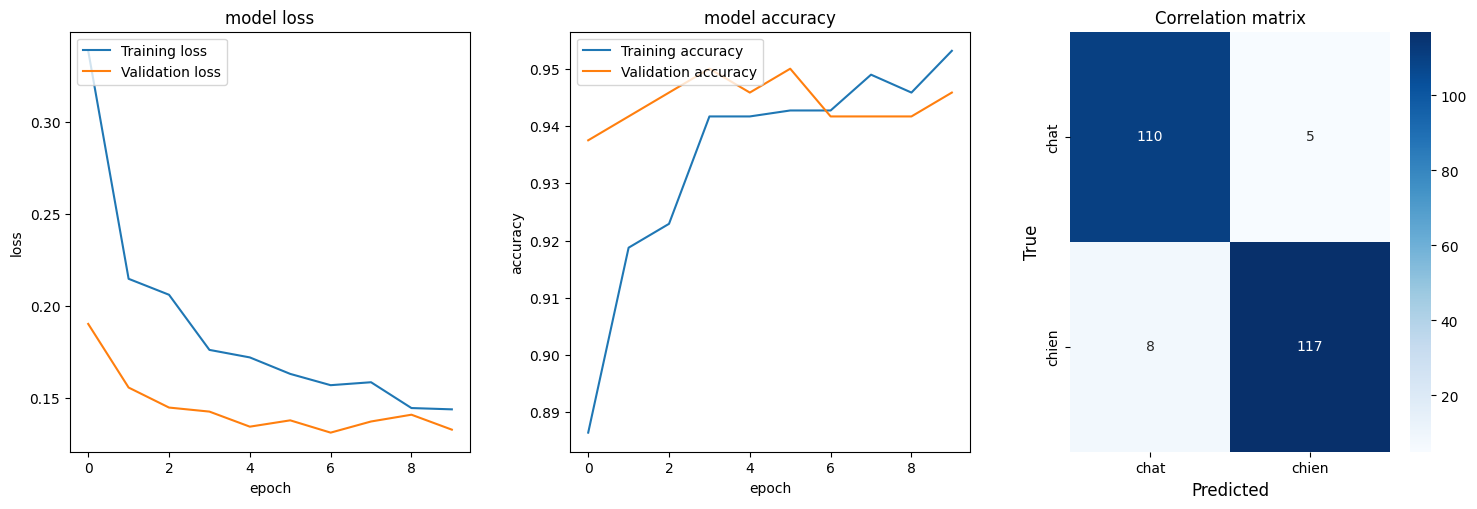

In [ ]:
y_pred = modelTransfertTest.predict(X_test_padded)
y_pred_rounded = [0 if k[0] <0.5 else 1 for k in y_pred]
conf=confusion_matrix(y_test,y_pred_rounded)
plot_curves_confusion(history_Yamnet_test, conf)